# Kerbside ID Pattern Analysis

**Objective**: Determine if kerbside IDs are sequential and spatially correlated to enable grouping for modeling.

**Strategy**: If kerbside IDs are spatially clustered (e.g., IDs 7000-7010 are near each other), we can group them and predict availability for groups rather than individual bays.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data

In [2]:
# Load Supabase snapshots
df = pd.read_csv('data/supabase_snapshots.csv')
print(f"Total records: {len(df):,}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Total records: 762,037

Columns: ['id', 'kerbsideid', 'status', 'status_timestamp', 'created_at']

First few rows:


,id,kerbsideid,status,status_timestamp,created_at
0,1,64015,Present,2025-11-28 09:43:56+00:00,2025-11-28 09:48:59.136225+00:00
1,2,60226,Unoccupied,2025-11-28 09:43:54+00:00,2025-11-28 09:48:59.136225+00:00
2,3,65245,Unoccupied,2025-11-28 09:43:52+00:00,2025-11-28 09:48:59.136225+00:00
3,4,63142,Unoccupied,2025-11-28 09:43:51+00:00,2025-11-28 09:48:59.136225+00:00
4,5,63340,Unoccupied,2025-11-28 09:43:49+00:00,2025-11-28 09:48:59.136225+00:00


## 2. Analyze Kerbside ID Distribution

In [3]:
# Get unique kerbside IDs
unique_kerbsides = df['kerbsideid'].unique()
print(f"Unique kerbside IDs: {len(unique_kerbsides):,}")
print(f"Min kerbside ID: {unique_kerbsides.min()}")
print(f"Max kerbside ID: {unique_kerbsides.max()}")
print(f"Range: {unique_kerbsides.max() - unique_kerbsides.min():,}")

Unique kerbside IDs: 3,309
Min kerbside ID: 5691
Max kerbside ID: 90812
Range: 85,121


## 3. Check if IDs are Sequential

In [4]:
# Sort kerbside IDs and check for gaps
sorted_ids = np.sort(unique_kerbsides)

# Calculate gaps between consecutive IDs
gaps = np.diff(sorted_ids)

print(f"Gap statistics:")
print(f"  Min gap: {gaps.min()}")
print(f"  Max gap: {gaps.max()}")
print(f"  Mean gap: {gaps.mean():.2f}")
print(f"  Median gap: {np.median(gaps):.0f}")
print(f"\nNumber of gaps by size:")
print(f"  Gap = 1 (sequential): {(gaps == 1).sum():,} ({(gaps == 1).sum() / len(gaps) * 100:.1f}%)")
print(f"  Gap <= 10: {(gaps <= 10).sum():,} ({(gaps <= 10).sum() / len(gaps) * 100:.1f}%)")
print(f"  Gap <= 100: {(gaps <= 100).sum():,} ({(gaps <= 100).sum() / len(gaps) * 100:.1f}%)")
print(f"  Gap > 100: {(gaps > 100).sum():,} ({(gaps > 100).sum() / len(gaps) * 100:.1f}%)")

Gap statistics:
  Min gap: 1
  Max gap: 23729
  Mean gap: 25.73
  Median gap: 1

Number of gaps by size:
  Gap = 1 (sequential): 2,704 (81.7%)
  Gap <= 10: 3,037 (91.8%)
  Gap <= 100: 3,223 (97.4%)
  Gap > 100: 85 (2.6%)


C:\Users\hsueh\AppData\Local\Temp\ipykernel_20376\61741489.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([gaps[gaps <= 10], gaps[(gaps > 10) & (gaps <= 100)], gaps[gaps > 100]],


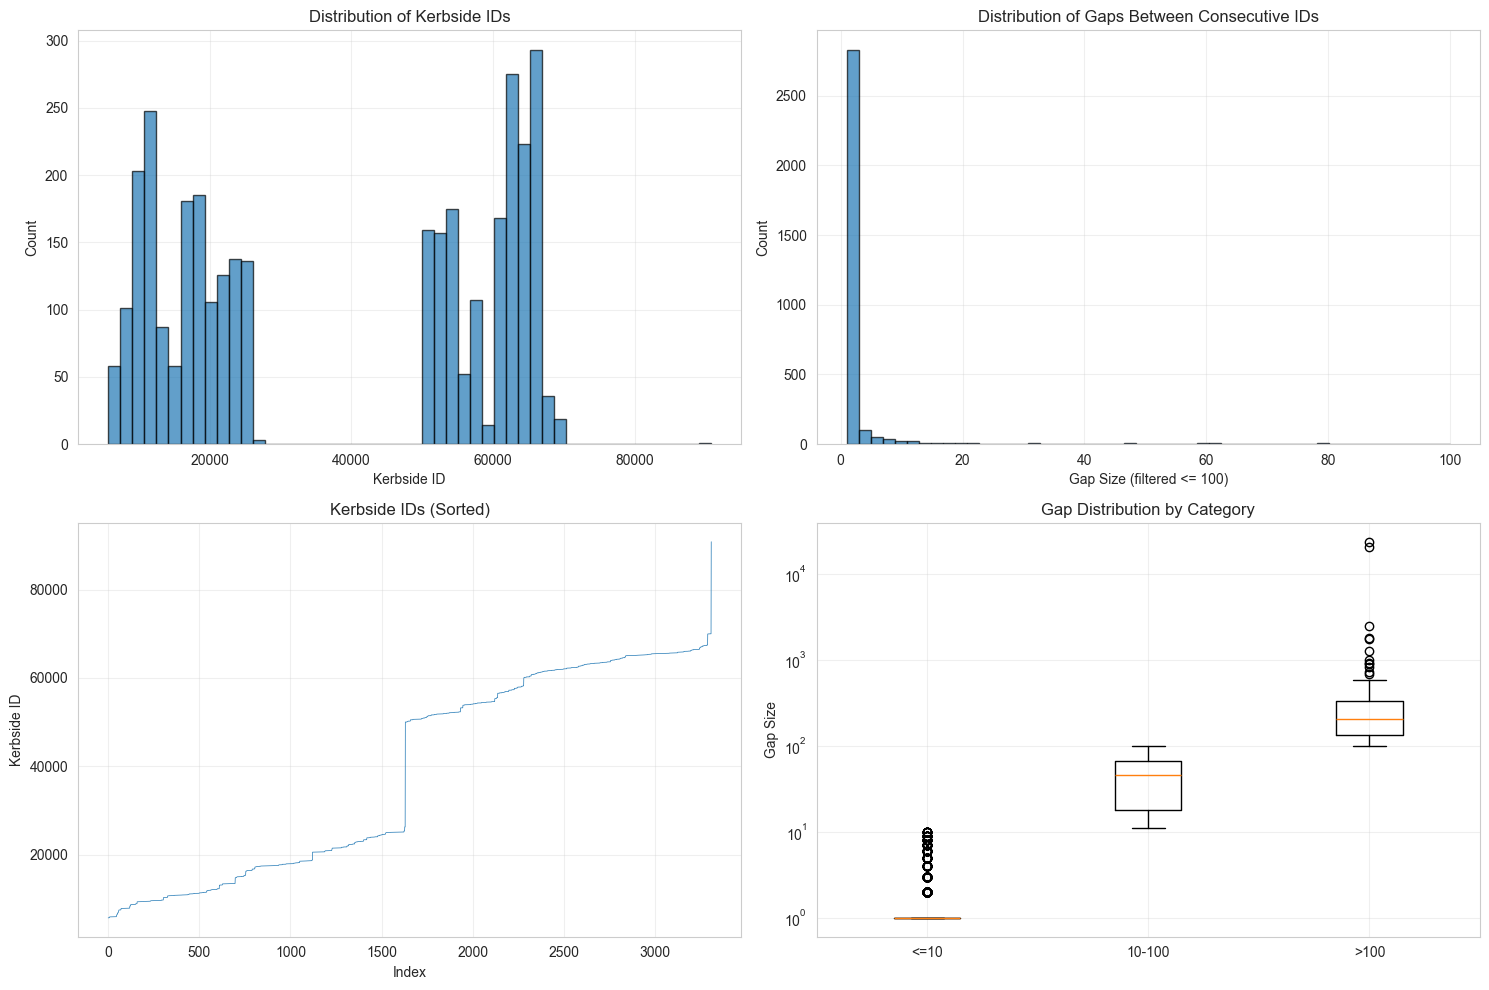

In [5]:
# Visualize distribution of kerbside IDs
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribution of kerbside IDs
axes[0, 0].hist(sorted_ids, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Kerbside ID')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of Kerbside IDs')
axes[0, 0].grid(True, alpha=0.3)

# 2. Gap distribution
axes[0, 1].hist(gaps[gaps <= 100], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Gap Size (filtered <= 100)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Distribution of Gaps Between Consecutive IDs')
axes[0, 1].grid(True, alpha=0.3)

# 3. Cumulative gaps
axes[1, 0].plot(range(len(sorted_ids)), sorted_ids, linewidth=0.5)
axes[1, 0].set_xlabel('Index')
axes[1, 0].set_ylabel('Kerbside ID')
axes[1, 0].set_title('Kerbside IDs (Sorted)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plot of gaps
axes[1, 1].boxplot([gaps[gaps <= 10], gaps[(gaps > 10) & (gaps <= 100)], gaps[gaps > 100]], 
                    labels=['<=10', '10-100', '>100'])
axes[1, 1].set_ylabel('Gap Size')
axes[1, 1].set_title('Gap Distribution by Category')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Identify ID Clusters/Ranges

In [6]:
# Define clusters based on kerbside ID ranges (thousands)
# Example: 7000-7999 = cluster 7, 8000-8999 = cluster 8, etc.

df['kerbside_cluster_1k'] = (df['kerbsideid'] // 1000) * 1000
df['kerbside_cluster_10k'] = (df['kerbsideid'] // 10000) * 10000

print("Number of bays per 1k cluster:")
cluster_1k_counts = df.groupby('kerbside_cluster_1k')['kerbsideid'].nunique().sort_index()
print(cluster_1k_counts)

print("\nNumber of bays per 10k cluster:")
cluster_10k_counts = df.groupby('kerbside_cluster_10k')['kerbsideid'].nunique().sort_index()
print(cluster_10k_counts)

Number of bays per 1k cluster:
kerbside_cluster_1k
5000      46
6000      11
7000      62
8000      40
9000     144
10000    141
11000    119
12000     47
13000     87
14000     19
15000     39
16000     50
17000    211
18000    105
20000    106
21000     89
22000     67
23000     76
24000     71
25000     97
26000      3
50000    108
51000    119
52000     76
53000     56
54000    132
55000     16
56000     61
57000     68
58000     14
60000     69
61000    148
62000    114
63000    153
64000     75
65000    323
66000     91
67000     36
69000     19
90000      1
Name: kerbsideid, dtype: int64

Number of bays per 10k cluster:
kerbside_cluster_10k
0         303
10000     818
20000     509
50000     650
60000    1028
90000       1
Name: kerbsideid, dtype: int64


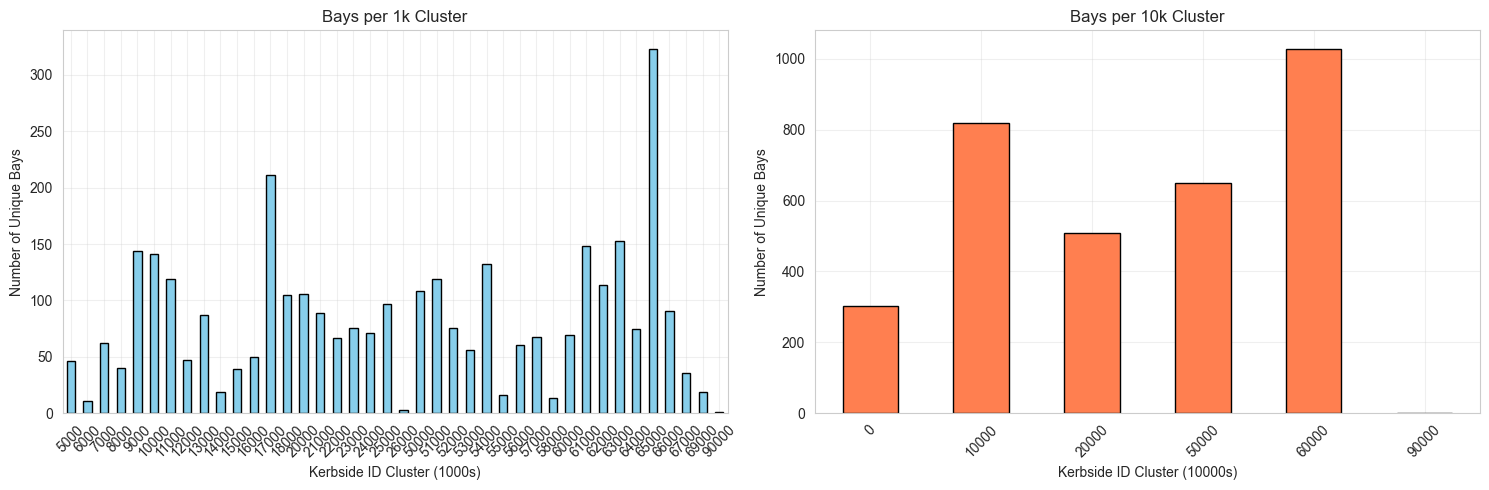

In [7]:
# Visualize clustering
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1k clusters
cluster_1k_counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Kerbside ID Cluster (1000s)')
axes[0].set_ylabel('Number of Unique Bays')
axes[0].set_title('Bays per 1k Cluster')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# 10k clusters
cluster_10k_counts.plot(kind='bar', ax=axes[1], color='coral', edgecolor='black')
axes[1].set_xlabel('Kerbside ID Cluster (10000s)')
axes[1].set_ylabel('Number of Unique Bays')
axes[1].set_title('Bays per 10k Cluster')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Test Specific Range (Example: 7000-7010)

In [8]:
# Check if IDs 7000-7010 exist and how many bays there are
test_range = df[(df['kerbsideid'] >= 7000) & (df['kerbsideid'] <= 7010)]
print(f"Bays in range 7000-7010:")
if len(test_range) > 0:
    unique_in_range = test_range['kerbsideid'].unique()
    print(f"  Unique IDs: {sorted(unique_in_range)}")
    print(f"  Count: {len(unique_in_range)}")
else:
    print("  No bays found in this range")

# Let's find a better example range with actual data
# Take the first 10k cluster with data
first_cluster = cluster_10k_counts.index[0]
example_range_start = first_cluster
example_range_end = first_cluster + 10

print(f"\nBetter example - Range {example_range_start}-{example_range_end}:")
test_range_2 = df[(df['kerbsideid'] >= example_range_start) & (df['kerbsideid'] <= example_range_end)]
if len(test_range_2) > 0:
    unique_in_range_2 = test_range_2['kerbsideid'].unique()
    print(f"  Unique IDs: {sorted(unique_in_range_2)}")
    print(f"  Count: {len(unique_in_range_2)}")
else:
    print("  No bays found in this range either")

Bays in range 7000-7010:
  No bays found in this range

Better example - Range 0-10:
  No bays found in this range either


## 6. Conclusion & Recommendation

Based on the analysis above, we can determine:

1. **Are kerbside IDs sequential?** Check the gap analysis
2. **Can we group by ID ranges?** Check if clusters have reasonable numbers of bays
3. **What grouping strategy makes sense?**
   - If IDs are mostly sequential with small gaps → Group by 10s or 100s
   - If IDs have large gaps → Group by 1000s or 10000s
   - If IDs are completely random → Need different strategy (spatial proximity)

**Run this notebook and report back with the results!**

In [9]:
# Summary statistics for easy reference
print("=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Total unique kerbside IDs: {len(unique_kerbsides):,}")
print(f"ID range: {unique_kerbsides.min()} - {unique_kerbsides.max()}")
print(f"Mean gap between IDs: {gaps.mean():.2f}")
print(f"Median gap: {np.median(gaps):.0f}")
print(f"Sequential IDs (gap=1): {(gaps == 1).sum() / len(gaps) * 100:.1f}%")
print(f"\nRecommended grouping strategy:")
if gaps.mean() < 5:
    print("  → IDs are mostly sequential - group by 10s (e.g., 7000-7009, 7010-7019)")
elif gaps.mean() < 50:
    print("  → IDs have small gaps - group by 100s (e.g., 7000-7099)")
elif gaps.mean() < 200:
    print("  → IDs have moderate gaps - group by 1000s (e.g., 7000-7999)")
else:
    print("  → IDs are not sequential - consider spatial grouping instead")
print("=" * 60)

SUMMARY
Total unique kerbside IDs: 3,309
ID range: 5691 - 90812
Mean gap between IDs: 25.73
Median gap: 1
Sequential IDs (gap=1): 81.7%

Recommended grouping strategy:
  → IDs have small gaps - group by 100s (e.g., 7000-7099)
